# End-to-End Lane Navigation 




In [7]:
model_output_dir = ''

In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Imports Packages

In [4]:

# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image


tf.__version__: 2.8.0
keras.__version__: 2.8.0


## Load Train Data

image_path: training_data\video1.avi_031_083.png
steering_Angle: 83


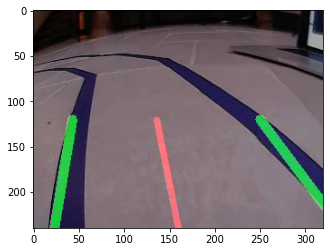

In [6]:
# import images
data_dir = 'training_data' #added underscore
file_list = os.listdir(data_dir)
image_paths = []
steering_angles = []
pattern = "*.png"
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(data_dir,filename))
        angle = int(filename[-7:-4])  # 092 part of video01_143_092.png is the angle. 90 is go straight
        steering_angles.append(angle)

image_index = 20
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index] )
print("steering_Angle: %d" % steering_angles[image_index] )
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles


(array([11.0000, 31.0000, 23.0000, 20.0000, 28.0000, 28.0000, 30.0000,
        145.0000, 197.0000, 180.0000, 113.0000, 58.0000, 94.0000, 55.0000,
        29.0000, 26.0000, 28.0000, 19.0000, 18.0000, 26.0000, 54.0000,
        35.0000, 27.0000, 7.0000, 16.0000]),
 array([66.0000, 69.2400, 72.4800, 75.7200, 78.9600, 82.2000, 85.4400,
        88.6800, 91.9200, 95.1600, 98.4000, 101.6400, 104.8800, 108.1200,
        111.3600, 114.6000, 117.8400, 121.0800, 124.3200, 127.5600,
        130.8000, 134.0400, 137.2800, 140.5200, 143.7600, 147.0000]),
 <BarContainer object of 25 artists>)

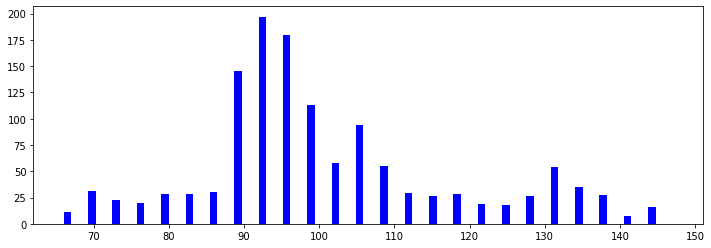

In [8]:
# Look at the distribution of steering angle
num_of_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

Training data: 1038
Validation data: 260


Text(0.5, 1.0, 'Validation Data')

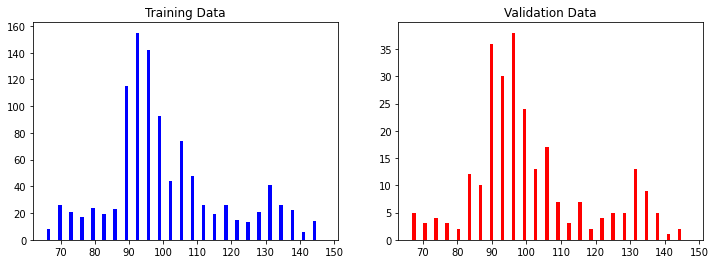

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split( image_paths, steering_angles, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

# plot the distributions of train and valid, make sure they are consistent
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')


##Image Augumentation
Since we only have a few hundred images, to train a deep network, we need a lot more images.   Instead of running our car, let's try to augment our data. There are a couple of ways to do that.

1. Zoom: crop out a smaller image from the center
1. Pan: crop out a smaller image from left or right side
1. adjust brightness of the image
1. flip the image horizontally, i.e do a left to right flip, and change the steering angle coorespondingly
1. introduce an Gaussian blur

We can combine the above augmentation techniques to generate 100s times of the training images, with just a few hundred real images.



Text(0.5, 1.0, 'blurred')

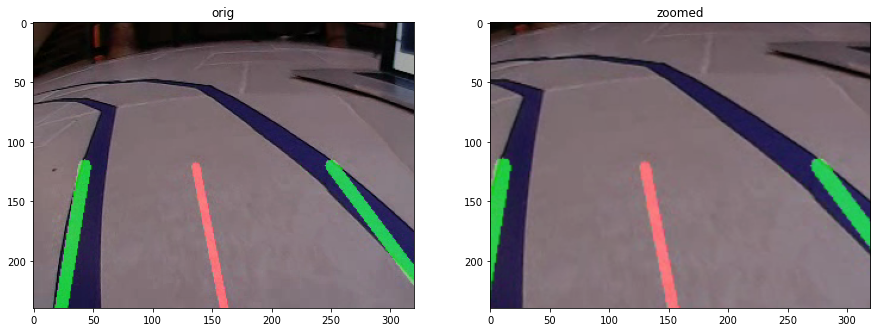

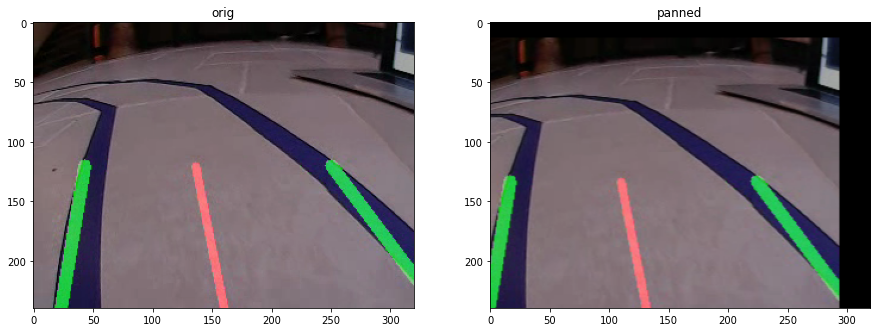

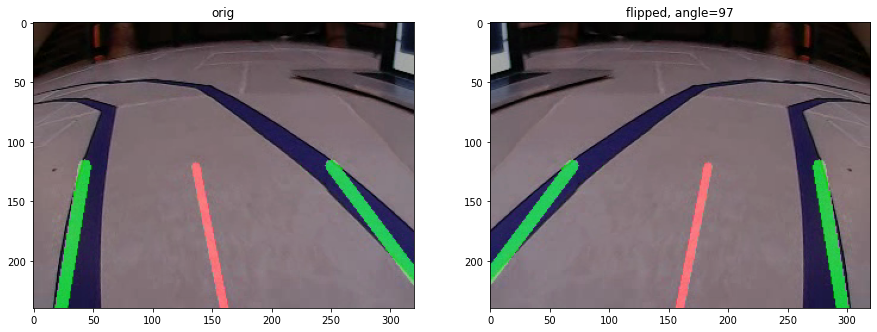

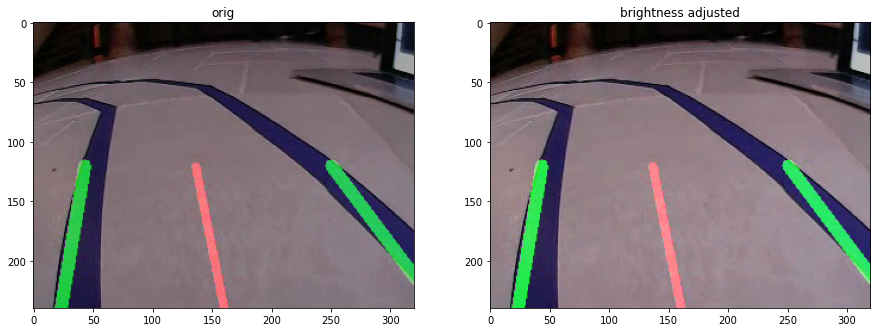

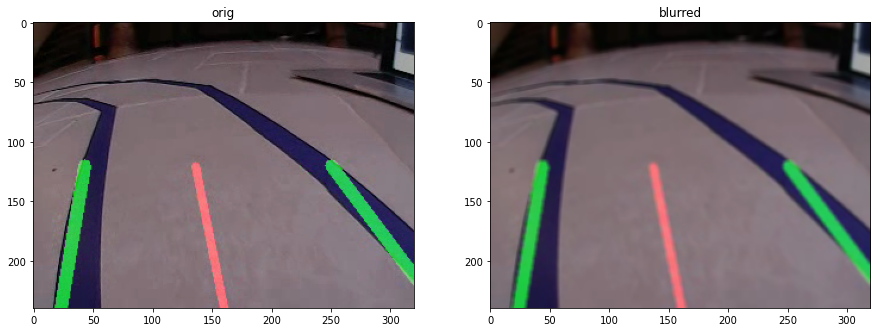

In [10]:
def my_imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image

def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

def blur(image):
    kernel_size = random.randint(1, 5)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
    return image

def random_flip(image, steering_angle):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        # randomly flip horizon
        image = cv2.flip(image,1)
        steering_angle = 180 - steering_angle
    return image, steering_angle

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_zoom = zoom(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_zoom)
axes[1].set_title("zoomed")

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_pan = pan(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_pan)
axes[1].set_title("panned")

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_flip, steering_angle = random_flip(image_orig, steering_angles[image_index])
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_flip)
axes[1].set_title("flipped, angle=%s" % steering_angle)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_brightness = adjust_brightness(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_brightness)
axes[1].set_title("brightness adjusted")

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_blur = blur(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_blur)
axes[1].set_title("blurred")

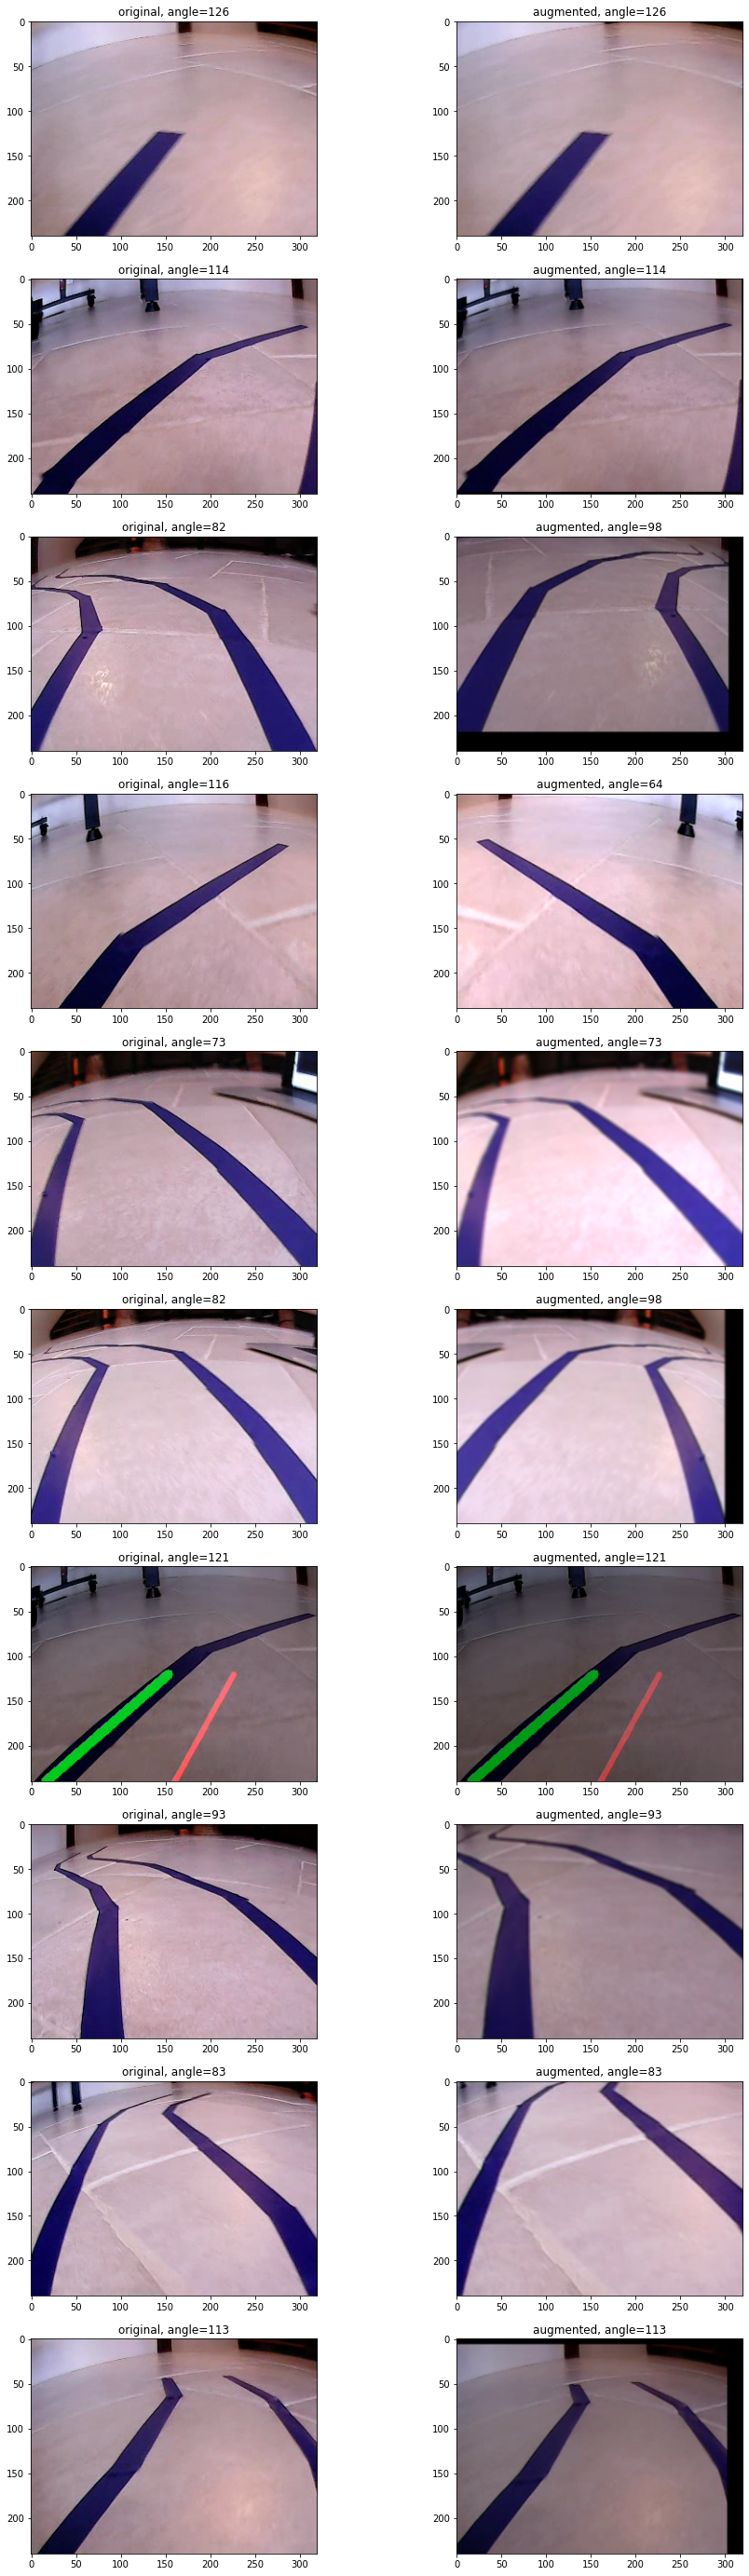

In [20]:
# put it together
def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    image, steering_angle = random_flip(image, steering_angle)
    
    return image, steering_angle

# show a few randomly augmented images
ncol = 2
nrow = 10
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 50))

for i in range(nrow):
    rand_index = random.randint(0, len(image_paths) - 1)
    image_path = image_paths[rand_index]
    steering_angle_orig = steering_angles[rand_index]
    
    image_orig = my_imread(image_path)
    image_aug, steering_angle_aug = random_augment(image_orig, steering_angle_orig)
    
    axes[i][0].imshow(image_orig)
    axes[i][0].set_title("original, angle=%s" % steering_angle_orig)
    axes[i][1].imshow(image_aug)
    axes[i][1].set_title("augmented, angle=%s" % steering_angle_aug)
    

## Preprocess Training Data

Text(0.5, 1.0, 'processed')

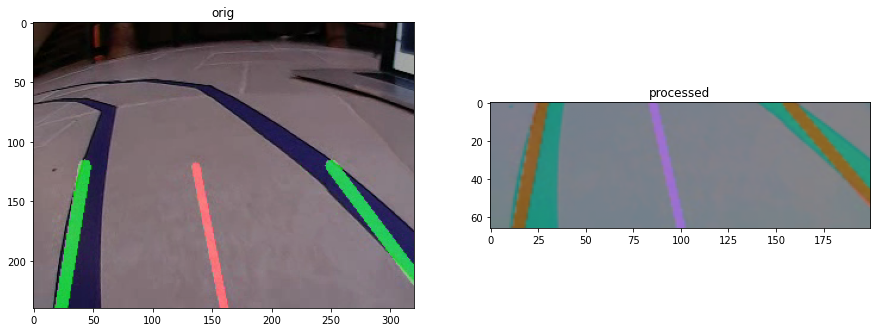

In [21]:
def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/2):,:,:]  # remove top half of the image, as it is not relavant for lane following
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,66)) # input image size (200,66) Nvidia model
    image = image / 255 # normalizing, the processed image becomes black for some reason.  do we need this?
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")


## Create and Train Model

In [28]:
def simple_model():
    model = Sequential(name='Simple_Model')
    
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers
    model = Sequential()
    model.add(Conv2D(4, (5, 5),padding="same", strides=(2, 2), input_shape=(66, 200, 3), activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(8, (5, 5), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(12, (5, 5), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())

    
    # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
    model.add(Dense(1000, activation="sigmoid"))
    model.add(Dense(750, activation="relu"))
    model.add(Dense(500, activation="relu"))
    model.add(Dense(250, activation="relu"))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(50, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(1, activation="linear"))

    model.add(Dense(1)) 
    
    # since this is a regression problem not classification problem,
    # we use MSE (Mean Squared Error) as loss function
    model.compile(loss='mse', optimizer='adam')
    
    return model

In [23]:
model = simple_model()
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 33, 100, 4)        304       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 50, 4)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 50, 8)         808       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 25, 8)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 25, 12)         2412      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 4, 12, 12)       

In [24]:
def image_data_generator(image_paths, steering_angles, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]
            if is_training:
                # training: augment image
                image, steering_angle = random_augment(image, steering_angle)
              
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))
            
            

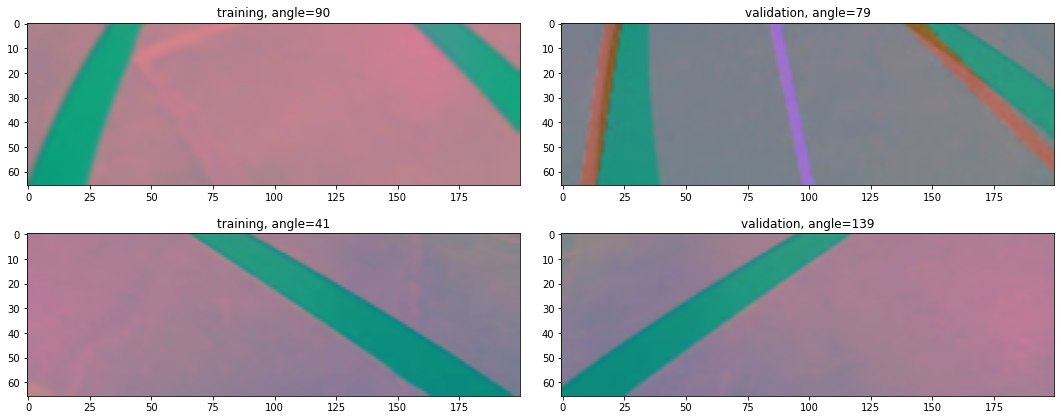

In [25]:
ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow, True))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow, False))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])


In [26]:
# start Tensorboard before model fit, so we can see the epoch tick in Tensorboard
# Jupyter Notebook embedded Tensorboard is a new feature in TF 2.0!!  

# clean up log folder for tensorboard
log_dir_root = f'{model_output_dir}/logs/'
#!rm -rf $log_dir_root


In [ ]:
# this block prevents the training from starting if we Run All
DO_NOT_RUN_ALL

In [29]:
# saves the model weights after each epoch if the validation loss decreased
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'lane_navigation_check.h5'), verbose=1, save_best_only=True)


history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=32, is_training=True),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=32, is_training=False),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
# always save model output as soon as model finishes training
model.save(os.path.join(model_output_dir,'lane_navigation_CNN.h5'))

date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)
    



Epoch 1/10
  1/300 [..............................] - ETA: 5s - loss: 115.0709

C:\Users\arcxo\AppData\Local\Temp\ipykernel_26108\1642392215.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=32, is_training=True),


300/300 [==============================] - ETA: 0s - loss: 112.4530
Epoch 1: val_loss improved from inf to 86.48759, saving model to lane_navigation_check.h5
300/300 [==============================] - 42s 140ms/step - loss: 112.4530 - val_loss: 86.4876
Epoch 2/10
300/300 [==============================] - ETA: 0s - loss: 105.6598
Epoch 2: val_loss improved from 86.48759 to 46.15313, saving model to lane_navigation_check.h5
300/300 [==============================] - 41s 137ms/step - loss: 105.6598 - val_loss: 46.1531
Epoch 3/10
300/300 [==============================] - ETA: 0s - loss: 93.7329
Epoch 3: val_loss did not improve from 46.15313
300/300 [==============================] - 41s 137ms/step - loss: 93.7329 - val_loss: 47.8821
Epoch 4/10
300/300 [==============================] - ETA: 0s - loss: 83.1333
Epoch 4: val_loss improved from 46.15313 to 42.82403, saving model to lane_navigation_check.h5
300/300 [==============================] - 41s 138ms/step - loss: 83.1333 - val_loss:

## Check Trained Model on Validation Data

In [30]:
history.history


{'loss': [112.45299530029297,
  105.65978240966797,
  93.7328872680664,
  83.13331604003906,
  79.40227508544922,
  77.8919906616211,
  78.1618423461914,
  72.65943908691406,
  71.544677734375,
  68.90493774414062],
 'val_loss': [86.48758697509766,
  46.15312957763672,
  47.88209533691406,
  42.824031829833984,
  30.383508682250977,
  26.91034698486328,
  40.56633377075195,
  26.15994644165039,
  33.18038558959961,
  27.933483123779297]}

In [31]:
def test_data_generator(image_paths, steering_angles, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            index = i
            image_path = image_paths[index]
            image = my_imread(image_paths[index])
            steering_angle = steering_angles[index]
            if is_training:
                # training: augment image
                image, steering_angle = image, steering_angle
              
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))


In [32]:
# plot training and validation losses
# this should be the same as tensorboard
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

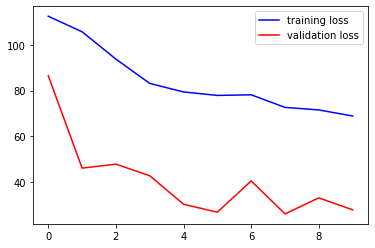

In [33]:
history
plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

In [35]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model_dir = 'lane_navigation_CNN.h5'
    model = load_model(model_dir)
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred

mse       = 2.5e+01
r_squared = 90.13%



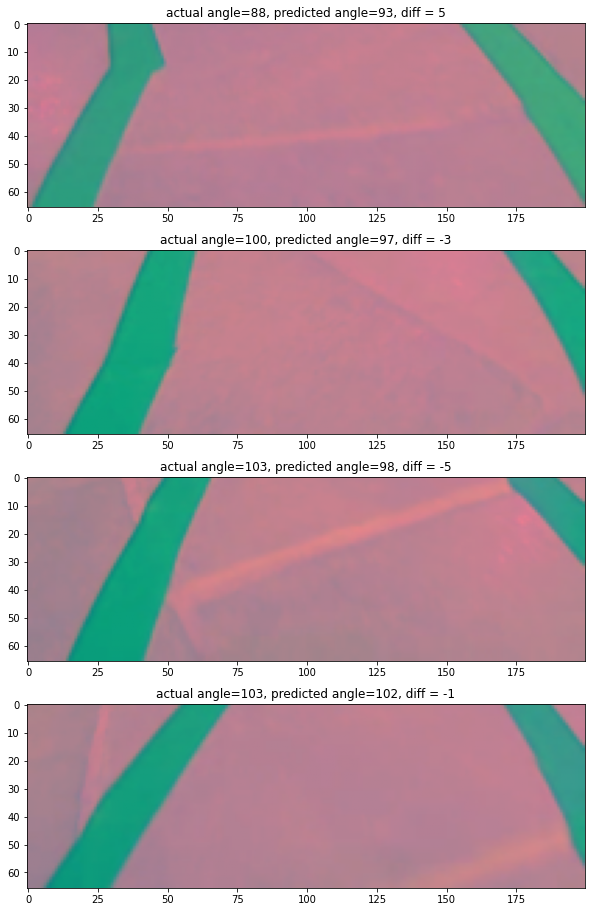

In [38]:
n_tests = 100

X_test, y_test = next(test_data_generator(X_valid, y_valid, 100, False))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 4
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")
    

In [37]:
model.save("experimental_model.h5")

## References
1. Mariusz Bojarski, Davide Del Testa, Daniel Dworakowski, Bernhard Firner, Beat Flepp, Prasoon Goyal, Lawrence D. Jackel, Mathew Monfort, Urs Muller, Jiakai Zhang, Xin Zhang, Jake Zhao, Karol Zieba (2016) *End to End Learning for Self-Driving Cars*. Nvidia 
1. Rayan Slim, Amer Sharaf, Jad Slim (2017) *The Complete Self-Driving Car Course*. Udemy
1. Keras Documentation (2019) https://github.com/keras-team/keras/

